In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error

from keras.models import Sequential
from keras.layers import InputLayer, Bidirectional, LSTM, Dense, Dropout
from keras.optimizers import Adam
from keras.losses import MeanSquaredError
from keras.metrics import RootMeanSquaredError
from keras.constraints import MaxNorm
from keras.callbacks import ModelCheckpoint

import time

In [2]:
filepath = 'C:/Users/ss230/Documents/Study/NSIDC/Edited Data/S_Sea_Ice_Index_Regional_Monthly_Data_G02135_v3.0.xlsx'
Indian_Extent = pd.read_excel(filepath, sheet_name='Indian-Extent-km^2')

In [3]:
import sys
sys.path.append('C:/Users/ss230/Documents/Study/NSIDC/SH/Bi_LSTM_Extent/')
import Function as fp

In [4]:
fp.month_mapping(Indian_Extent)
fp.date_time(Indian_Extent)

Extent       Date
0     376618.799 1979-01-01
1     211788.726 1979-02-01
2     262868.141 1979-03-01
3     698377.304 1979-04-01
4    1252407.727 1979-05-01
..           ...        ...
533  1520776.003 2023-06-01
534  2076164.165 2023-07-01
535  2731799.027 2023-08-01
536  3179384.692 2023-09-01
537  3301335.210 2023-10-01

[538 rows x 2 columns]

In [5]:
scaler = MinMaxScaler()
Indian_Extent['Extent'] = scaler.fit_transform(Indian_Extent['Extent'].values.reshape(-1, 1))

In [6]:
def df_to_X_y(df, window_size):
    df_as_np = df.to_numpy()
    X = []
    y = []
    lead_time = 8
    for i in range(len(df_as_np) - window_size - lead_time + 1):
        window_data = df_as_np[i:i+window_size]
        row = [[a] for a in window_data]
        X.append(row)
        label = df_as_np[i+window_size+lead_time-1]
        y.append(label)
    return np.array(X), np.array(y)

In [7]:
extent = Indian_Extent['Extent']
W_S=12
X,y = df_to_X_y(extent, W_S)
X.shape, y.shape

((519, 12, 1), (519,))

In [8]:
X_train, y_train = X[:420], y[:420]
X_val, y_val = X[420:472], y[420:472]
X_test, y_test = X[472:], y[472:]

In [9]:
model = Sequential()
model.add(InputLayer((W_S, 1)))
model.add(Bidirectional(LSTM(128, activation='relu', kernel_constraint=MaxNorm(1.0), return_sequences=True)))
model.add(Dropout(0.5))
model.add(Bidirectional(LSTM(64, activation='relu', kernel_constraint=MaxNorm(1.0), return_sequences=True)))
model.add(Dropout(0.2))
model.add(Bidirectional(LSTM(32, activation='relu', kernel_constraint=MaxNorm(1.0))))
model.add(Dense(1, activation='linear'))

cp = ModelCheckpoint('Indian_model_LT8/', save_best_only=True)
model.compile(loss=MeanSquaredError(), optimizer=Adam(0.0001), metrics=[RootMeanSquaredError()])

In [10]:
stime = time.time()
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=50, batch_size=8, callbacks=[cp])
etime = time.time()

Epoch 1/50
53/53 [==============================] - 38s 508ms/step - loss: 0.2339 - root_mean_squared_error: 0.4836 - val_loss: 0.1466 - val_root_mean_squared_error: 0.3828
Epoch 2/50
53/53 [==============================] - 25s 484ms/step - loss: 0.1055 - root_mean_squared_error: 0.3249 - val_loss: 0.0770 - val_root_mean_squared_error: 0.2775
Epoch 3/50
53/53 [==============================] - 26s 492ms/step - loss: 0.0782 - root_mean_squared_error: 0.2797 - val_loss: 0.0621 - val_root_mean_squared_error: 0.2491
Epoch 4/50
53/53 [==============================] - 25s 487ms/step - loss: 0.0615 - root_mean_squared_error: 0.2480 - val_loss: 0.0471 - val_root_mean_squared_error: 0.2170
Epoch 5/50
53/53 [==============================] - 25s 480ms/step - loss: 0.0438 - root_mean_squared_error: 0.2093 - val_loss: 0.0290 - val_root_mean_squared_error: 0.1704
Epoch 6/50
53/53 [==============================] - 27s 511ms/step - loss: 0.0270 - root_mean_squared_error: 0.1642 - val_loss: 0.0179 

Epoch 29/50
53/53 [==============================] - 3s 47ms/step - loss: 0.0056 - root_mean_squared_error: 0.0747 - val_loss: 0.0033 - val_root_mean_squared_error: 0.0571
Epoch 30/50
53/53 [==============================] - 21s 396ms/step - loss: 0.0054 - root_mean_squared_error: 0.0737 - val_loss: 0.0028 - val_root_mean_squared_error: 0.0527
Epoch 31/50
53/53 [==============================] - 4s 78ms/step - loss: 0.0054 - root_mean_squared_error: 0.0736 - val_loss: 0.0033 - val_root_mean_squared_error: 0.0577
Epoch 32/50
53/53 [==============================] - 4s 75ms/step - loss: 0.0057 - root_mean_squared_error: 0.0754 - val_loss: 0.0030 - val_root_mean_squared_error: 0.0547
Epoch 33/50
53/53 [==============================] - 4s 78ms/step - loss: 0.0048 - root_mean_squared_error: 0.0691 - val_loss: 0.0035 - val_root_mean_squared_error: 0.0591
Epoch 34/50
53/53 [==============================] - 28s 541ms/step - loss: 0.0046 - root_mean_squared_error: 0.0680 - val_loss: 0.0024 - 

In [11]:
time = (etime - stime)/60
print(f'{time} minutes')

13.858437124888102 minutes


In [12]:
loss = history.history['loss']
epochs = list(range(1, len(loss) + 1))

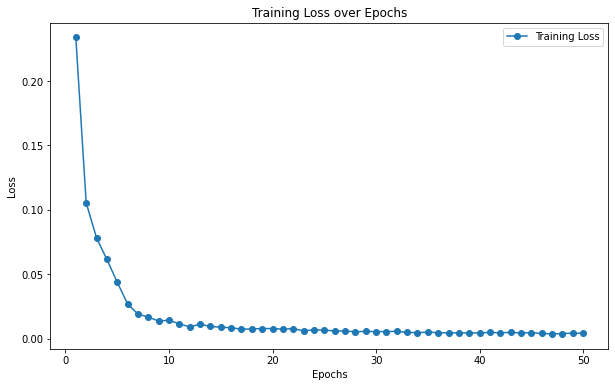

In [13]:
plt.figure(figsize=(10, 6))
plt.plot(epochs, loss, label='Training Loss', marker='o', linestyle='-')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.legend()
plt.show()

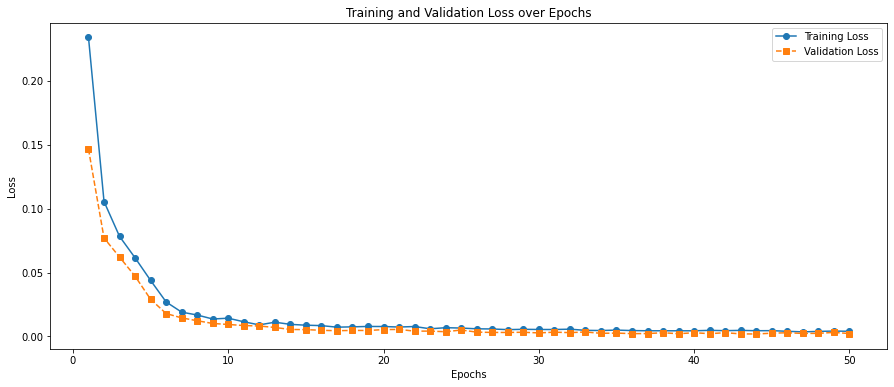

In [14]:
training_loss = history.history['loss']
validation_loss = history.history['val_loss']
epochs = range(1, len(training_loss) + 1)

plt.figure(figsize=(15,6))
plt.plot(epochs, training_loss, label='Training Loss', marker='o', linestyle='-')
plt.plot(epochs, validation_loss, label='Validation Loss', marker='s', linestyle='--')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss over Epochs')
plt.legend()
plt.show()

In [15]:
from tensorflow.keras.models import load_model
model1 = load_model('Indian_model_LT8/')

In [16]:
test_predictions = model1.predict(X_test)

2/2 [==============================] - 2s 26ms/step


In [17]:
mse = mean_squared_error(y_test, test_predictions)
print('RMSE :', np.sqrt(mse))

mae = mean_absolute_error(y_test, test_predictions)
print('MAE :', mae)

RMSE : 0.047066803540187656
MAE : 0.03941841112940047


In [18]:
test_predictions = scaler.inverse_transform(test_predictions)
test_original = scaler.inverse_transform(y_test.reshape(-1,1))

In [19]:
train_results = pd.DataFrame(data={'Train Predictions': test_predictions.flatten(), 'Actual Extent': test_original.flatten()})
train_results

Train Predictions  Actual Extent
0        1.389690e+06    1128752.378
1        3.973902e+05     522831.371
2        8.169721e+04     346601.304
3        1.378260e+05     444914.605
4        4.996909e+05     827036.916
5        1.081779e+06    1142021.216
6        1.787273e+06    1885693.654
7        2.527133e+06    2542569.663
8        3.054758e+06    3107373.845
9        3.366693e+06    3488175.444
10       3.432049e+06    3746306.528
11       2.783382e+06    2942322.822
12       1.412101e+06    1507212.955
13       5.051012e+05     648507.437
14       1.510500e+05     352564.010
15       2.186069e+05     453587.503
16       6.361380e+05     841043.793
17       1.284756e+06    1433155.266
18       1.985913e+06    2163687.646
19       2.633354e+06    2848863.133
20       3.091248e+06    3420877.229
21       3.417876e+06    3752886.938
22       3.482220e+06    3778951.818
23       2.784772e+06    2892177.223
24       1.435326e+06    1467610.428
25       4.628813e+05     377930.941
26       1.701751e+05     146440.376
27       2.686596e+05     244356.473
28       6.873249e+05     612217.566
29       1.266158e+06    1261627.075
30       1.986035e+06    1720565.225
31       2.713725e+06    2564005.541
32       3.244876e+06    2983773.529
33       3.589434e+06    3372645.223
34       3.544567e+06    3589687.043
35       2.611499e+06    2669385.189
36       1.171203e+06    1095398.946
37       2.474352e+05     319828.826
38       8.856455e+03     162541.182
39       1.181112e+05     179564.232
40       5.231382e+05     593196.107
41       1.136473e+06    1053508.835
42       1.831294e+06    1520776.003
43       2.508628e+06    2076164.165
44       3.051916e+06    2731799.027
45       3.373601e+06    3179384.692
46       3.428944e+06    3301335.210

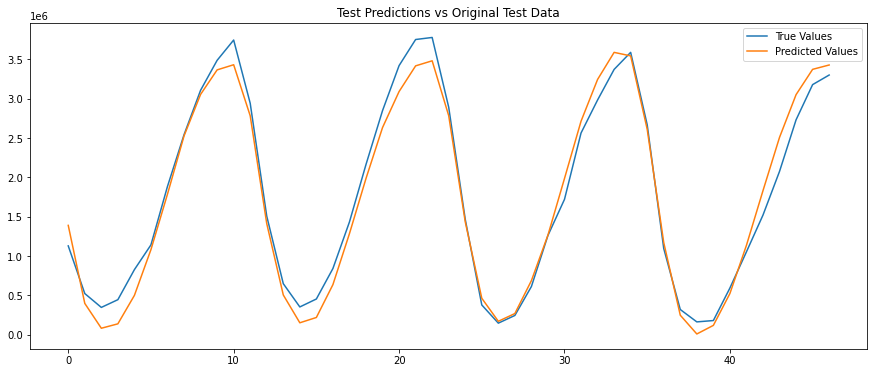

In [20]:
plt.figure(figsize=(15,6))
plt.plot(test_original, label='True Values')
plt.plot(test_predictions, label='Predicted Values')
plt.title('Test Predictions vs Original Test Data')
plt.legend()
plt.show()

In [21]:
predictions = model1.predict(X)

17/17 [==============================] - 1s 40ms/step


In [22]:
predictions = scaler.inverse_transform(predictions)
Original = scaler.inverse_transform(y.reshape(-1,1))

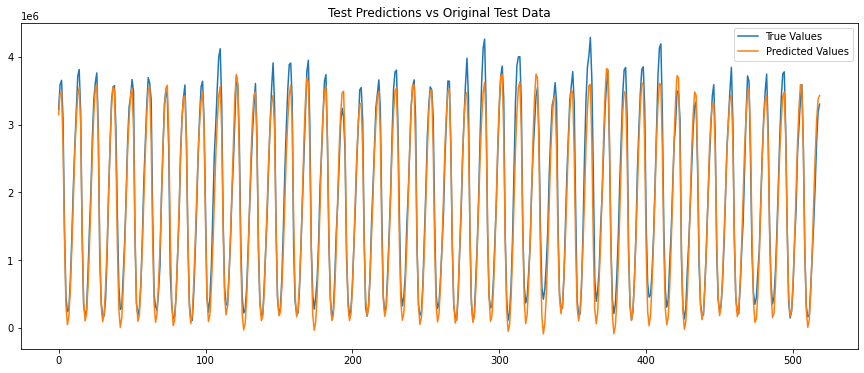

In [23]:
plt.figure(figsize=(15,6))
plt.plot(Original, label='True Values')
plt.plot(predictions, label='Predicted Values')
plt.title('Test Predictions vs Original Test Data')
plt.legend()
plt.show()